# PySpark (Apache Spark con Python)

## 0. Introducción y motivación – ¿Por qué usar PySpark/Spark?

Apache Spark es un motor de **análisis de datos a gran escala** que permite el procesamiento distribuido de grandes conjuntos de datos de forma rápida y sencilla. Fue diseñado para superar las limitaciones de tecnologías previas como Hadoop MapReduce, ofreciendo un procesamiento **en memoria** mucho más veloz y una interfaz de alto nivel en múltiples lenguajes (Scala, Java, Python, R). Su API para Python es conocida como **PySpark**, y nos permite aprovechar la potencia de Spark usando el lenguaje Python. A diferencia de bibliotecas como Pandas (que operan en un solo equipo y en memoria), PySpark está pensado para **escalar horizontalmente** en clústeres de múltiples nodos, siendo ideal para trabajar con volúmenes de datos que no caben en la memoria de un solo ordenador o para acelerar cómputos mediante paralelismo masivo.

**¿Cuándo conviene usar PySpark en lugar de Pandas o SQL?** Cuando los datos son muy grandes o las operaciones muy costosas. Pandas funciona en memoria local y es excelente para datasets que caben en RAM y para análisis rápidos en un solo equipo, pero cuando los datos crecen (millones de registros o más) Pandas se vuelve lento o imposible de usar por límites de memoria. Spark, en cambio, distribuye los datos y el cómputo en varios nodos, pudiendo manejar desde gigabytes hasta petabytes de información. Internamente, Spark optimiza las consultas mediante planificación de tareas (DAG scheduler) y evalúa las operaciones **de forma diferida (lazy evaluation)**: es decir, construye un plan de ejecución y solo procesa los datos cuando se le solicita un resultado (una *acción*). Esto permite optimizar todo el flujo antes de ejecutar, aplicando técnicas como *pipelining* y combinando operaciones, lo que resulta en un rendimiento muy alto en cargas de trabajo intensivas.

Además, Spark es un entorno unificado que incluye varios módulos integrados (SQL/DataFrames, streaming en tiempo real, machine learning con MLlib, gráficos con GraphX, etc.), por lo que es muy versátil. En contexto empresarial, Spark se ha convertido en un estándar de facto para **Big Data**, permitiendo ejecutar análisis complejos en clusters (ya sea on-premise o en la nube) con relativa facilidad. PySpark en particular es popular entre científicos de datos porque permite usar Python (y sus librerías como Pandas, NumPy, etc.) en entornos distribuidos, integrándose bien con herramientas existentes.

En resumen, **las ventajas clave de Spark/PySpark** son:

* **Velocidad**: Usa procesamiento en memoria y ejecución distribuida, logrando órdenes de magnitud más rapidez que enfoques basados en disco (como Hadoop MapReduce) especialmente en algoritmos iterativos y consultas interactivas. Su motor optimiza las consultas antes de ejecutarlas y aprovecha todos los núcleos disponibles en el clúster.
* **Escalabilidad horizontal**: Puede manejar grandes volúmenes de datos repartiendo el trabajo entre múltiples nodos del cluster. Basta con añadir más nodos para aumentar la capacidad de cómputo y almacenamiento, logrando escalar a *big data* real. El mismo código PySpark que corre en tu portátil con una pequeña muestra puede ejecutarse en un clúster de decenas o cientos de máquinas sobre toda la data.
* **Facilidad de uso y familiaridad**: Ofrece APIs de alto nivel similares a las de Pandas o SQL, lo que hace más sencillo para desarrolladores y analistas adoptar Spark. Puedes escribir consultas en PySpark de forma declarativa (por ejemplo, usando operaciones estilo DataFrame o incluso sentencias SQL) sin tener que preocuparte por detalles bajos de paralelismo. Además, al ser Python, es posible reutilizar conocimiento de bibliotecas como Pandas (incluso existe una API Pandas sobre Spark, que veremos más adelante).
* **Confiabilidad y tolerancia a fallos**: Spark maneja automáticamente la tolerancia a fallos mediante la replicación de datos (con su abstracción de RDDs - Resilient Distributed Datasets) y recomputación de particiones en caso de que algún nodo falle. El desarrollador no tiene que gestionar manualmente estos detalles.
* **Ecosistema y versatilidad**: Spark no solo sirve para SQL batch, sino que soporta procesamiento de streams en tiempo real, machine learning distribuido, y más, todo en el mismo framework. Esto evita tener que integrar múltiples herramientas distintas para casos de uso diferentes.

En definitiva, PySpark nos permite **lo mejor de dos mundos**: escribir código en Python de alto nivel (similar a Pandas/SQL) pero con capacidad de ejecutarse de forma distribuida sobre grandes volúmenes de datos. Si tu dataset es pequeño (digamos, menos de unos pocos millones de filas), Pandas probablemente sea más sencillo y suficiente. Pero si estás manejando datos **“grandes” (big data)** o quieres aprovechar un cluster de cómputo para acelerar tareas, PySpark es una excelente elección.



&#x20;*Arquitectura de un clúster Spark:* el programa *driver* (que contiene el `SparkContext` dentro de nuestra aplicación PySpark) se comunica con un *Cluster Manager* para solicitar recursos, y lanza procesos *executor* en los nodos trabajadores del clúster. Los *executors* ejecutan las tareas en paralelo y almacenan datos en memoria o disco (cache) según sea necesario. Gracias a esta arquitectura maestro-trabajador, Spark distribuye la carga de trabajo entre los nodos, manteniendo los datos redundantes para tolerancia a fallos y escalando eficientemente.


![Sin título.png](<attachment:Sin título.png>)
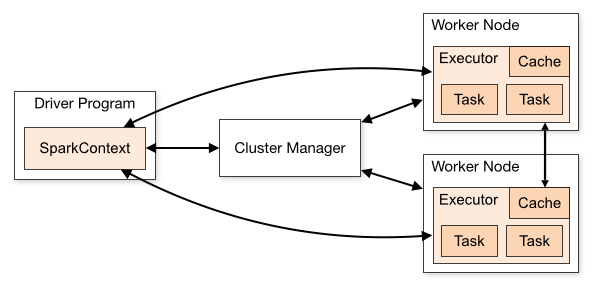


## 1. Instalación inicial: entorno con Docker y PySpark

Para empezar a trabajar con PySpark, configuraremos un entorno local que simula un clúster Spark usando **Docker**, mientras ejecutamos Python (nuestro driver) desde fuera del contenedor. De esta forma, podemos tener fácilmente un *cluster* Spark en nuestra máquina de desarrollo sin instalar Spark directamente en el host. Los pasos generales serán:

* **Instalar Java en el sistema host** (donde correrá PySpark): Spark corre sobre la JVM, por lo que incluso usando PySpark es necesario tener Java instalado en la máquina donde ejecutamos el driver. Si no se tiene Java, PySpark no iniciará (lanzará errores de `JAVA_HOME` no definido). Asegúrate de tener Java 8+ instalado y la variable de entorno `JAVA_HOME` configurada apuntando al JRE/JDK instalado.

* **Descargar una imagen Docker de Apache Spark**: Usaremos una imagen preconfigurada que incluya Spark. Una opción recomendada es la imagen oficial de Bitnami, que ya viene con Spark y Python instalados. Por ejemplo, podemos utilizar la versión 3.3.1 de Spark con Python 3.8 ejecutando:

  ```bash
  docker pull bitnami/spark:3.3.1
  ```

  > *Nota:* Es importante elegir una imagen cuya versión de Spark y Python coincida con la que usaremos en nuestro código PySpark. Por ejemplo, la imagen `bitnami/spark:3.3.1` trae Spark 3.3.1 y Python 3.8; por tanto, en nuestro entorno Python deberemos instalar `pyspark==3.3.1` y usar Python 3.8 para evitar incompatibilidades de serialización entre el driver y los executors. Si usamos versiones que no coinciden exactamente (por ejemplo Spark 3.3 en el clúster pero pyspark 3.2 en el driver), es probable que veamos errores de incompatibilidad al enviar tareas al cluster.



* **Lanzar un clúster Spark en contenedores**: Vamos a ejecutar dos contenedores: uno actuará como **Master** de Spark y otro como **Worker** (ejecutor). Esto constituye un mini-clúster Spark *standalone*. Primero, crea una red Docker para que los contenedores se comuniquen:

  ```bash
  docker network create spark-net
  ```

  Luego ejecuta el contenedor del *master*:

  ```bash
  docker run -d --name spark-master \
    -p 8080:8080 -p 7077:7077 \
    --network spark-net \
    -e SPARK_MODE=master \
    bitnami/spark:3.3.1
  ```

  Este comando inicia el Master de Spark en modo standalone. Mapeamos el puerto 8080 del contenedor al 8080 local (para acceder al UI web del master) y el puerto 7077 (puerto donde el master escucha las solicitudes de conexión de drivers y workers).  A continuación, iniciamos uno o más *workers* que se conecten al master:

  ```bash
  docker run -d --name spark-worker-1 \
    --network spark-net \
    -e SPARK_MODE=worker \
    -e SPARK_MASTER_URL=spark://spark-master:7077 \
    bitnami/spark:3.3.1
  ```

  Este contenedor iniciará un proceso Worker que se registrará en el Master (cuyo hostname en la red de Docker es `spark-master`). Puedes repetir este comando (cambiando el nombre del contenedor) para lanzar múltiples workers si lo deseas. Con esto, ya tenemos un clúster Spark en marcha: un master y (al menos) un worker ejecutándose.



* **Preparar el entorno Python (driver)**: En tu máquina host (o donde ejecutes el notebook de Jupyter), instala la misma versión de PySpark y Python que la imagen Docker. Si usas conda o venv, crea un entorno con, por ejemplo, Python 3.8 y PySpark 3.3.1:

  ```bash
  pip install pyspark==3.3.1
  ```

  (*Si estás en un Jupyter Notebook, también puedes instalarlo directamente en la celda.*) Esto nos permitirá usar `pyspark` en nuestro código para conectarnos al cluster.

* **Conectar PySpark al cluster**: Ya con el cluster corriendo y PySpark instalado en el host, podemos escribir un script o notebook Python y crear una SparkSession apuntando al master. Por ejemplo, en Python:

  ```python
  from pyspark.sql import SparkSession

  spark = SparkSession.builder \
      .appName("PySparkTutorial") \
      .master("spark://localhost:7077") \
      .getOrCreate()
  ```

  Aquí usamos la dirección `spark://localhost:7077` porque expusimos el puerto 7077 de nuestro master al host local. Esto inicializa una **SparkSession**, el punto de entrada principal para trabajar con Spark SQL y DataFrames. La SparkSession representa la conexión a nuestro cluster Spark; al crearla, Spark buscará al master en esa dirección y registrará nuestra aplicación (**appName**) en el cluster. Si todo está correcto, la sesión se creará y el master asignará recursos (por defecto, usará todos los núcleos disponibles en los workers, pero esto se puede configurar).

  > *Tip:* Si en lugar de un cluster quisiéramos correr Spark en modo local (sin Docker), podríamos usar `.master("local[*]")` para indicar que use todos los núcleos locales. Esto lanza procesos *executor* en hilos del mismo proceso Python. Este modo es útil para pruebas rápidas, pero carece de los beneficios de escalado del cluster.

* **Verificar la instalación**: Podemos probar una operación sencilla para comprobar que todo funciona. Por ejemplo, contar números de 1 a 1000 en paralelo:

  ```python
  rdd = spark.sparkContext.parallelize(range(1, 1001))
  print("Cuenta:", rdd.count())
  ```

  Si la instalación es correcta, esta operación distribuirá la secuencia en el cluster, contará los elementos y devolverá `1000` como resultado (el número de elementos). Al ejecutarla, puedes visitar en tu navegador `http://localhost:8080` para ver la interfaz web del Spark Master, donde debería aparecer tu aplicación activa, y también `http://localhost:4040` para ver la interfaz web del driver (Spark UI) con detalles de la tarea ejecutada.

En este punto, tenemos nuestro entorno PySpark listo: un cluster Spark corriendo en Docker y una sesión Spark accesible desde Python. A continuación, empezaremos a explorar las funcionalidades de PySpark a través de su API de **DataFrames**, comparándola con herramientas conocidas como Pandas y SQL.



## 2. DataFrames y estructuras de datos en PySpark

En Spark, la principal abstracción de alto nivel para manejar datos estructurados es el **DataFrame**. Un DataFrame de Spark es muy similar a una tabla en una base de datos relacional o a un DataFrame de Pandas: es decir, es una colección de datos organizados en filas y columnas, con un esquema bien definido (nombres de columnas y tipos de datos). Internamente, los DataFrames de PySpark están respaldados por RDDs (Resilient Distributed Datasets), pero expuestos a usuario con una API mucho más cómoda y optimizada, incluyendo muchas operaciones de selección, filtrado, agregación, etc., todo de forma *declarativa*.

¿Por qué usar DataFrames y no RDDs directamente? Porque Spark puede aplicar optimizaciones avanzadas (a través de un componente llamado **Catalyst Optimizer**) cuando trabajamos con DataFrames y consultas SQL, generando planes de ejecución eficientes. Además, el código es más conciso y fácil de leer. De hecho, en la mayoría de los casos de uso (ETL, análisis de datos, machine learning), se recomienda usar DataFrames/Datasets en lugar de RDDs puros, ya que **son más sencillos y suelen rendir mejor**. Solo en situaciones muy específicas de bajo nivel conviene manejar RDDs directamente.

**Creación de una SparkSession**: Antes de crear o cargar cualquier DataFrame, necesitamos tener una `SparkSession` activa (como hicimos en la sección anterior). En un entorno interactivo (por ejemplo, usando el shell `pyspark` o algunas distribuciones), la SparkSession a veces ya existe pre-creada. En nuestros scripts o notebooks, como vimos, la creamos manualmente. Recordemos importar la clase necesaria:

```python
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("spark://localhost:7077").appName("TutorialPySpark").getOrCreate()
```

*(Ajusta el master y appName según tu configuración; si sigues con el ejemplo Docker anterior, `spark://localhost:7077` está bien. Si estás en modo local puro sin cluster, usarías `"local[*]"`.)*

Una vez tenemos la SparkSession (`spark`), ya podemos crear DataFrames.

### Cargando datos en un DataFrame

Existen múltiples formas de obtener un DataFrame en PySpark:

* **Leer desde un archivo o fuente de datos** (CSV, JSON, Parquet, una tabla SQL, etc.).
* **Convertir una colección de objetos locales o Pandas DataFrame** a un DataFrame distribuido de Spark.
* **Partir de un RDD existente** y transformarlo a DataFrame indicando un esquema.

Veamos ejemplos comunes:

**a) Leer un archivo CSV/JSON**: La SparkSession proporciona lectores para distintos formatos. Por ejemplo, si tenemos un archivo CSV con datos, podemos hacer:

```python
# Leer un CSV con inferencia de esquema y cabeceras
df = spark.read.option("inferSchema", "true").option("header", "true").csv("ruta/al/archivo.csv")
```

Esto carga el CSV en un DataFrame `df`, intentando inferir automáticamente el tipo de dato de cada columna y tratando la primera línea como cabecera (nombres de columna). Alternativamente, podríamos especificar manualmente un esquema o ajustar opciones (separador, formato de fecha, codificación, etc.) según el caso. PySpark también permite leer JSON (`spark.read.json("file.json")`), Parquet (`spark.read.parquet(...)`), avro, etc., así como fuentes externas (por ejemplo, una tabla en Hive, o mediante JDBC a una base SQL).

**b) A partir de datos en Python (lista, diccionario, Pandas)**: Si ya tenemos datos en una estructura Python, podemos crear un DataFrame directamente. Un caso útil es cuando tienes un DataFrame de **Pandas** y quieres pasarlo a Spark (por ejemplo, porque inicialmente los datos cabían en Pandas pero ahora quieres distribuirlos):

```python
import pandas as pd

# Ejemplo: dataset "iris" de scikit-learn cargado en pandas
iris_pd = pd.DataFrame({
    "sepal_length": [5.1, 4.9, 4.7, 4.6, 5.0],
    "sepal_width":  [3.5, 3.0, 3.2, 3.1, 3.6],
    "petal_length": [1.4, 1.4, 1.3, 1.5, 1.4],
    "petal_width":  [0.2, 0.2, 0.2, 0.2, 0.2],
    "species":      ["setosa", "setosa", "setosa", "setosa", "setosa"]
})
print(iris_pd.head())
#   sepal_length  sepal_width  petal_length  petal_width species
# 0           5.1          3.5           1.4          0.2  setosa
# 1           4.9          3.0           1.4          0.2  setosa
# ...
```

Tenemos un pequeño DataFrame de Pandas con cinco filas de ejemplo (columnas numéricas y una categórica de especie). Para convertirlo a un DataFrame Spark:

```python
df = spark.createDataFrame(iris_pd)
df.printSchema()
```

Cuando usamos `createDataFrame` con un pandas.DataFrame, PySpark utiliza Arrow (si está disponible) para convertirlo de manera eficiente. El resultado `df` es un DataFrame distribuido (aunque con estos pocos datos seguirá siendo solo una partición). El `printSchema()` nos mostraría el esquema inferido:

```
root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)
```

Como vemos, Spark infiere los tipos: las columnas numéricas son *double* (coma flotante de 64 bits) y la columna de texto es *string*. Todas aparecen como *nullable = true* (Spark permite por defecto nulos en todas las columnas a menos que se especifique lo contrario).

También podríamos crear un DataFrame a partir de, por ejemplo, una lista de tuplas o un RDD. Por ejemplo:

```python
data = [("Ana", 34), ("Juan", 45), ("Pedro", 23)]
df2 = spark.createDataFrame(data, schema=["nombre", "edad"])
df2.show()
# +------+---+
# |nombre|edad|
# +------+---+
# |   Ana| 34 |
# |  Juan| 45 |
# |  Pedro| 23 |
# +------+---+
```

Aquí pasamos una lista de tuplas y definimos los nombres de columna en el esquema. Spark asignó tipos (edad como long, nombre como string). Si no pasamos schema, Spark habría dado nombres genéricos `_1`, `_2`, ... a las columnas.

**c) Esquemas explícitos**: En casos avanzados, podemos crear esquemas usando tipos de datos de Spark (`pyspark.sql.types.StructType`, `StructField`, etc.) para definir exactamente los tipos y nombres, y luego aplicarlos al crear el DataFrame. Esto es útil cuando queremos asegurarnos de los tipos o para CSVs sin cabecera, etc. En la mayoría de situaciones, inferir o usar schema simples como listas de nombres es suficiente.

Una vez obtenido un DataFrame, es importante entender que **las transformaciones en Spark son *vagas (lazy)* y los DataFrames son inmutables**. Al aplicar operaciones (filtros, selects, etc.) no se ejecutan inmediatamente, sino que Spark construye internamente un plan (un grafo de operaciones) y postergará la ejecución hasta que necesitemos un resultado concreto (por ejemplo al hacer un `show()` o un `count()` que requiera calcular algo). Asimismo, cada transformación genera un *nuevo* DataFrame (no modifica el existente), dado que los DataFrames (y RDDs) son inmutables. Esto difiere de Pandas, donde sí podemos modificar un DataFrame en memoria. En PySpark, si haces `df2 = df.filter(...)`, `df` sigue existiendo igual; `df2` es un nuevo DataFrame con la transformación aplicada. Esta naturaleza inmutable facilita la tolerancia a fallos y la reproducción de cálculos en el cluster.

### Exploración inicial del DataFrame

Al igual que en Pandas usamos `df.head()` o `df.info()`, en PySpark tenemos algunas acciones para inspeccionar el contenido y estructura:

* `df.show(n)` – Muestra las primeras *n* filas del DataFrame (20 por defecto) en formato tabular, útil para vistazo rápido. Por ejemplo `df.show(5)`.
* `df.printSchema()` – Muestra el esquema (estructuras de columnas y tipos).
* `df.columns` – Lista con los nombres de las columnas.
* `df.describe().show()` – Calcula estadísticas descriptivas básicas (count, mean, stddev, min, max) para columnas numéricas, similar a `pandas.DataFrame.describe`.

Por ejemplo:

```python
df.show(5)
# +------------+-----------+------------+-----------+-------+
# |sepal_length|sepal_width|petal_length|petal_width|species|
# +------------+-----------+------------+-----------+-------+
# |         5.1|        3.5|         1.4|        0.2| setosa|
# |         4.9|        3.0|         1.4|        0.2| setosa|
# |         4.7|        3.2|         1.3|        0.2| setosa|
# |         4.6|        3.1|         1.5|        0.2| setosa|
# |         5.0|        3.6|         1.4|        0.2| setosa|
# +------------+-----------+------------+-----------+-------+
```

Tenemos 5 filas del DataFrame iris con las columnas que definimos. Observa que el método `show()` es el que **dispara realmente la ejecución**: Spark leerá o calculará los datos necesarios para mostrar esas filas. Si el dataset fuera enorme, `show(5)` solo trae 5 filas (lo justo para mostrarlas), lo cual es práctico para examinar datos sin volcar todo el dataset.

Con el DataFrame listo, pasemos a realizar operaciones comunes: **seleccionar columnas, filtrar filas, crear columnas derivadas, agrupar, ordenar, juntar dataframes, etc.** Iremos comparando con cómo se haría en Pandas o SQL cuando sea relevante.

## 3. Operaciones de *slicing* y filtrado de datos

Una de las tareas más básicas en análisis de datos es **seleccionar un subconjunto de columnas o filas** que nos interesan. En Pandas haríamos cosas como `df[["col1","col2"]]` para columnas o `df[df["col"] > 5]` para filtrar filas. Veamos cómo lograr equivalentes en PySpark.

### Seleccionar columnas (*slicing* de columnas)

Para elegir columnas específicas de un DataFrame de Spark, usamos principalmente el método `.select()`. Ejemplos:

```python
# Seleccionar solo un subconjunto de columnas
df_subset = df.select("sepal_length", "sepal_width", "species")
df_subset.show(5)
# +------------+-----------+-------+
# |sepal_length|sepal_width|species|
# +------------+-----------+-------+
# |         5.1|        3.5| setosa|
# |         4.9|        3.0| setosa|
# |         4.7|        3.2| setosa|
# |         4.6|        3.1| setosa|
# |         5.0|        3.6| setosa|
# +------------+-----------+-------+
```

También podemos **renombrar columnas** en la selección usando `alias` (o posteriormente con `withColumnRenamed`, que veremos). Por ejemplo, digamos que queremos renombrar `sepal_length` a `sepal_len` solo en la vista seleccionada:

```python
from pyspark.sql.functions import col
df.select(col("sepal_length").alias("sepal_len"), col("species")).show(3)
# +---------+-------+
# |sepal_len|species|
# +---------+-------+
# |      5.1| setosa|
# |      4.9| setosa|
# |      4.7| setosa|
# +---------+-------+
```

*(Aquí importamos `col` de `pyspark.sql.functions` para referirnos a columnas por nombre; también podríamos usar directamente strings en select como antes.)*

Spark no soporta exactamente la sintaxis `df["col"]` para obtener un subconjunto de DataFrame como hace Pandas. En Spark, `df["col"]` devuelve un objeto `Column` (una representación de la columna para usar en expresiones). De hecho, una forma alternativa de seleccionar es pasar esa columna a `.select` o usar `df.select(df["col1"], df["col2"])`. Pero la forma más clara suele ser `df.select("col1","col2",...)` o usando `col("col")` para funciones más complejas.

Si queremos seleccionar **todas las columnas excepto algunas**, podemos usar `df.drop("colA","colB")` para quitar columnas no deseadas. Por ejemplo `df.drop("target").printSchema()` quitaría la columna target del esquema. También existe un atajo `df.select("*")` para indicar "todas las columnas".

### Filtrado de filas por condición

El filtrado en PySpark se realiza usando el método `.filter()` o su alias `.where()`, pasando una expresión booleana. A diferencia de Pandas, **no** podemos usar la notación `df[df.col > 5]` directamente; tenemos que construir la condición con las Column de PySpark. Ejemplos:

Supongamos que en nuestro DataFrame `df` de iris queremos las filas donde `sepal_length > 5.0`. En PySpark:

```python
df_filtered = df.filter(df.sepal_length > 5.0)
df_filtered.show(5)
# (muestra 5 filas donde sepal_length es mayor a 5.0)
```

También podríamos escribir la condición con `col`:

```python
from pyspark.sql.functions import col
df.filter(col("sepal_length") > 5.0).show(5)
```

Ambos son equivalentes. Incluso es posible pasar la condición como string estilo SQL, por ejemplo `df.filter("sepal_length > 5.0 AND species = 'virginica'")`, aunque perderíamos el chequeo de errores en tiempo de compilación (es menos seguro si el string está mal escrito). Usar `df.colname` o `col("name")` es más común.

**Condiciones compuestas:** Para combinar varias condiciones, utilizamos los operadores `&` (AND lógico) y `|` (OR lógico), recordando envolver cada comparación entre paréntesis. Por ejemplo, filas donde `sepal_length > 5.0` **y** la `species` sea *virginica*:

```python
df.filter( (df.sepal_length > 5.0) & (df.species == "virginica") ).show(5)
```

O filas donde `species` sea *setosa* **o** *versicolor*:

```python
df.filter( (df.species == "setosa") | (df.species == "versicolor") ).show()
```

Recuerda que en PySpark usamos `==` para comparar columnas a valores (no un solo `=`), y que los operadores son sobrecargados para producir Columnas booleanas. **¡Atención!:** en Pandas uno a veces olvida poner los paréntesis o usa `and`/`or` en vez de `&`/`|`, lo cual en Pandas ya causa error. En PySpark es obligatorio usar `&` y `|` bit a bit, y siempre con cada comparación entre `(...)`.

También existe la función `df.where(...)` que es exactamente lo mismo que `filter` (alias semántico, para quien prefiera la analogía SQL de *WHERE*).

Veamos un ejemplo concreto con nuestro dataset iris: queremos filtrar las muestras de *versicolor* con anchura de sépalo mayor a 3:

```python
df.filter( (df.species == "versicolor") & (df.sepal_width > 3.0) ).show()
# +------------+-----------+------------+-----------+----------+
# |sepal_length|sepal_width|petal_length|petal_width|   species|
# +------------+-----------+------------+-----------+----------+
# |         7.0|        3.2|         4.7|        1.4|versicolor|
# |         6.4|        3.2|         4.5|        1.5|versicolor|
# |         6.9|        3.1|         4.9|        1.5|versicolor|
# ... (etc)
```

**Filtrar valores nulos:** Si queremos eliminar filas con valores nulos en ciertas columnas, PySpark ofrece métodos específicos (`df.dropna()`, con opciones para umbrales, subset de columnas, etc.). Por ejemplo, `df.dropna(subset=["col1","col2"])` eliminaría filas donde *col1* o *col2* sean nulos. Para reemplazar nulos por un valor dado, está `df.fillna(valor, subset=[...])`. En nuestro dataset de ejemplo no tenemos nulos, pero es muy común en la práctica.

**Eliminar duplicados:** Para quitar duplicados podemos usar `df.distinct()` que devuelve las filas únicas considerando todas las columnas, o `df.dropDuplicates(["colA","colB"])` para considerar solo un subset como clave. Esto es análogo a un `SELECT DISTINCT` en SQL o `df.drop_duplicates()` en Pandas.

Ejemplo rápido: si tuviésemos duplicados en iris (no debería haber, pero supongamos), `df.select("species").distinct().show()` nos daría las especies únicas (setosa, versicolor, virginica). Este patrón se usa mucho para obtener dimensiones o valores únicos.

### Extra: Selección por posición o muestra aleatoria

A diferencia de Pandas, no tenemos `.iloc` o `.loc` porque el DataFrame no está ordenado intrínsecamente (y está distribuido). Si necesitamos una muestra de filas, podemos usar `df.limit(n)` para las primeras *n* filas (orden de aparición no definido a menos que se aplique un sort previo) o `df.sample(fraction=0.1)` para una fracción aleatoria. También existe `df.sampleBy(col, fractions={valor: prob, ...})` para muestreo estratificado según una columna categórica.

Por ejemplo, `df.sample(False, 0.1).show()` daría \~10% de las filas aleatoriamente (el primer argumento indica si es con reemplazo o no, casi siempre False).

En la práctica, para *ver* datos es mejor usar `limit` después de ordenar, para tener una vista consistente, o simplemente usar `show()` que ya limita.

Ahora que sabemos seleccionar columnas y filtrar filas, pasemos a operaciones más complejas: **agrupamientos y agregaciones**.

## 4. Operaciones de agrupamiento (GroupBy y agregaciones)

Agrupar datos por alguna clave y aplicar funciones de agregación (suma, promedio, conteo, etc.) es otra tarea esencial en análisis de datos, equivalente al `GROUP BY` de SQL o `groupby` de Pandas. PySpark proporciona la operación `groupBy` en DataFrames que nos devuelve un objeto de agrupamiento sobre el cual podemos aplicar agregaciones.

La interfaz es ligeramente distinta a Pandas: en Pandas haríamos `df.groupby("col").agg({"otra_col":"mean"})` por ejemplo. En PySpark podemos hacer:

```python
df.groupBy("species").agg({"sepal_length": "avg"}).show()
```

Pero suele ser más claro usar las funciones de agregación de `pyspark.sql.functions` explicítamente, por ejemplo:

```python
from pyspark.sql.functions import avg, count, max, min

df.groupBy("species") \
  .agg(
      count("*").alias("count"),
      avg("sepal_length").alias("avg_sepal_length"),
      avg("sepal_width").alias("avg_sepal_width")
  ) \
  .show()
```

Supongamos que ejecutamos lo anterior en el dataset iris (que tiene 150 filas, 50 por especie). Obtendríamos algo como:

```
+----------+-----+----------------+---------------+
|   species|count|avg_sepal_length|avg_sepal_width|
+----------+-----+----------------+---------------+
|    setosa|   50|            5.01|           3.42|
|virginica|   50|            6.59|           2.97|
|versicolor|   50|            5.94|           2.77|
+----------+-----+----------------+---------------+
```

Aquí vemos 3 grupos (las especies únicas) con el tamaño de cada grupo y los promedios de longitud y anchura de sépalo en cada especie.

Veamos otro ejemplo de agrupamiento: usando un dataset ficticio de ventas, podríamos agrupar por país y año para sumar ingresos, etc. En el tutorial de Spark de Datacamp, por ejemplo, agrupan por país para contar clientes distintos:

```python
# (ejemplo adaptado)
from pyspark.sql.functions import countDistinct

df_sales.groupBy("Country") \
    .agg(countDistinct("CustomerID").alias("num_customers")) \
    .orderBy("num_customers", ascending=False) \
    .show()
```

Esto daría el número de clientes por país, ordenados de mayor a menor. La función `countDistinct` (o su alias `countDistinct`) es equivalente a COUNT(DISTINCT col) en SQL.

Algunas **funciones de agregación comunes** disponibles (en `pyspark.sql.functions`): `count()`, `countDistinct()`, `sum()`, `avg()`/`mean()`, `min()`, `max()`, `stddev()`, `first()`, `last()`, `collect_list()` (recoger todos los valores en una lista), entre muchas otras. Puedes consultar la documentación de PySpark para la lista completa. También es posible definir **agregaciones personalizadas** (aunque es más avanzado, con `UserDefinedAggregateFunction` o usando funciones de ventana).

**Atajo**: Si quisieras hacer simplemente una agregación global (no groupBy, sino sobre todo el DataFrame), puedes usar métodos como `df.count()` (cuenta total de filas), o `df.agg(max("col"), min("col2")).show()`, etc. Por ejemplo, `df_sales.agg({"Revenue": "sum"}).show()` te da la suma de la columna Revenue en todo el DF.

**GroupBy vs SQL**: Todo lo que hacemos con groupBy se puede hacer también registrando el DataFrame como una tabla temporal y lanzando una consulta SQL. Por ejemplo:

```python
df.createOrReplaceTempView("iris_table")
spark.sql("""
    SELECT species, COUNT(*) as count,
           AVG(sepal_length) as avg_sepal_length
    FROM iris_table
    GROUP BY species
    """).show()
```

Esto produciría el mismo resultado que el groupBy anterior, pero escrito en SQL. Úsalo si te sientes más cómodo con SQL o si quieres aprovechar sintaxis complejas de SQL (Spark SQL soporta bastante de ANSI SQL, funciones ventana, etc.). Recuerda que la tabla temporal solo vive en esa SparkSession.

### Ejemplo de agrupación práctica

Tomemos nuestro DataFrame `df` de iris. Podemos preguntar: ¿cuál es el *ancho* medio de pétalo por cada especie, y cuántas muestras hay de cada una?:

```python
from pyspark.sql.functions import round

result = df.groupBy("species") \
           .agg(
               count("*").alias("count"),
               round(avg("petal_width"), 2).alias("avg_petal_width")
           )
result.show()
# +----------+-----+---------------+
# |   species|count|avg_petal_width|
# +----------+-----+---------------+
# |    setosa|   50|           0.25|
# |virginica|   50|           2.03|
# |versicolor|   50|           1.33|
# +----------+-----+---------------+
```

Aquí incluimos `round` para limitar a 2 decimales el promedio de ancho de pétalo (solo por presentación). Vemos que setosa tiene 50 muestras con ancho medio \~0.25, etc.

**Ordenar los resultados agrupados:** Muchas veces, tras agrupar queremos ordenar por el valor agregado. En Spark, simplemente encadenamos un `.orderBy()` o `.sort()` después de la agregación, como se ve en el ejemplo con num\_customers arriba. Por ejemplo, `result.orderBy("avg_petal_width", ascending=False).show()` ordenaría las especies del ancho de pétalo promedio mayor al menor (virginica primero en este caso).

**Filtrar después de agrupar:** ¿Y si quisiéramos, por ejemplo, filtrar grupos por alguna condición agregada (como un HAVING en SQL)? Una forma es calcular la agregación y luego filtrar el DataFrame resultante. Otra forma es usar las funciones de agregación en una expresión filter: Spark 3.4 introdujo `.filter` después de groupBy (pandas API style), pero la manera más clara es hacer el groupBy.agg en un DF y luego filtrar sobre él:

```python
result.filter(result["count"] > 40).show()
```

Esto mostraría solo las especies con más de 40 muestras (que son todas en iris). En SQL habríamos escrito `HAVING count(*) > 40`.

En resumen, agrupar en PySpark es muy poderoso y similar a SQL. **Comparación con Pandas**: la principal diferencia es sintaxis. En Pandas podrías hacer `df.groupby("species")["petal_width"].mean()`, que devuelve una Series, etc. En PySpark, cada agregación devuelve un nuevo DataFrame con las columnas de grupo más las agregadas. No hay un concepto de *GroupBy object* que se imprima por sí solo; siempre necesitas una agregación final para obtener resultados. Además, las funciones disponibles cubren lo típico; para cosas como mediana o percentiles, hay funciones especiales (`approxQuantile` para estimar percentiles, o usar expr SQL).

## 5. Otras operaciones avanzadas en PySpark DataFrames

En esta sección revisaremos otras operaciones comunes que no hemos cubierto pero que son típicas al trabajar con datos, comparando con cómo se haría en Pandas cuando aplique. Incluiremos: uniones (joins) entre DataFrames, ordenamiento (*sorting*), añadir o transformar columnas, manejo de datos faltantes, y algunas consideraciones de rendimiento.

### 5.1 Joins (unir DataFrames por una clave)

La combinación de conjuntos de datos por una clave es soportada en Spark de forma similar a SQL y Pandas (merge). Podemos usar tanto la API DataFrame como expresiones SQL para hacer *joins*. Supongamos que tenemos dos DataFrames: `df_people` con columnas `persona_id, nombre, edad`, y `df_ciudad` con `ciudad_id, nombre_ciudad, pais`. Si quisiéramos unir la información de la persona con la de su ciudad natal (asumiendo que `df_people` tiene una columna `ciudad_id`), haríamos:

```python
df_people.join(df_ciudad, on="ciudad_id", how="inner").show()
```

Aquí Spark realizará por defecto un *inner join* (equivalente a `how="inner"` explícito) usando la columna común `ciudad_id`. Podemos especificar tipos de join: `"inner"`, `"left"`, `"right"`, `"outer"` (full outer), `"left_semi"` (semi join), `"left_anti"` (anti join, útil para encontrar registros en A que no tienen correspondencia en B). Si las columnas llave tienen distinto nombre, debemos usar la sintaxis con expresión de condición:

```python
dfA.join(dfB, dfA.key == dfB.otherKey, how="left")
```

o incluso múltiples condiciones encadenadas con `&`.

Otra opción es renombrar previamente alguna columna para que coincidan los nombres y usar el parámetro `on=["colNameA","colNameB"]`.

**Ejemplo práctico de join:** Volvamos al dataset iris. Supongamos que tenemos un segundo DataFrame que da información adicional de cada especie, por ejemplo:

```python
info = [("setosa", "color azul"), 
        ("versicolor", "color amarillo"), 
        ("virginica", "color rojo")]
df_info = spark.createDataFrame(info, ["species", "flower_color"])
df_info.show()
# +----------+--------------+
# |   species|  flower_color|
# +----------+--------------+
# |    setosa|    color azul|
# | versicolor|color amarillo|
# | virginica|     color rojo|
# +----------+--------------+
```

Ahora queremos agregar la columna `flower_color` al DataFrame principal `df` uniendo por `species`. Hacemos:

```python
df_joined = df.join(df_info, on="species", how="inner")
df_joined.select("sepal_length","sepal_width","species","flower_color").show(5)
# +------------+-----------+-------+--------------+
# |sepal_length|sepal_width|species|  flower_color|
# +------------+-----------+-------+--------------+
# |         5.1|        3.5| setosa|    color azul|
# |         4.9|        3.0| setosa|    color azul|
# |         4.7|        3.2| setosa|    color azul|
# |         4.6|        3.1| setosa|    color azul|
# |         5.0|        3.6| setosa|    color azul|
# +------------+-----------+-------+--------------+
```

Vemos que se añadió correctamente la información del color para cada fila según la especie. Un detalle: si el DataFrame de la derecha tuviera columnas con el mismo nombre que las de la izquierda (aparte de la llave), Spark las renombraría agregando sufijos (`_right`) automáticamente para diferenciar. Podemos evitar conflictos seleccionando solo columnas necesarias o renombrando antes del join.

**Joins usando SQL**: Alternativamente podríamos hacer `spark.sql("SELECT ... FROM df LEFT JOIN otherdf ...")` tras crear vistas temporales, como se mostró antes. Spark SQL soporta las sintaxis JOIN estándar.

**Broadcast join (tip avanzado)**: Si uno de los DataFrames es pequeño (p. ej., una tabla de dimensión) y el otro muy grande, Spark automáticamente o manualmente puede hacer un *broadcast join*, enviando la tabla pequeña a cada nodo en lugar de hacer shuffle de la grande. Si Spark no lo hace por sí solo, se puede forzar con `broadcast(df_small)` en la expresión de join (importando `from pyspark.sql.functions import broadcast`). Esto optimiza mucho los joins tipo dimensión.

### 5.2 Ordenamiento (sort)

Ordenar un DataFrame por valores de columna es similar a SQL (`ORDER BY`) o Pandas (`sort_values`). En PySpark usamos `.orderBy()` o su sinónimo `.sort()`. Ejemplos:

```python
# Ordenar iris por sepal_length ascendentemente:
df.orderBy("sepal_length", ascending=True).show(5)

# Ordenar descendentemente, dos formas equivalentes:
from pyspark.sql.functions import desc
df.orderBy(desc("sepal_length")).show(5)

df.sort(df.sepal_length.desc()).show(5)
```

También podemos ordenar por múltiples columnas, por ejemplo primero por especie alfabéticamente y luego por sepal\_length desc:

```python
df.sort("species", df.sepal_length.desc()).show(5)
```

En el contenido de ejemplo, muestran varias maneras y confirmación de que `sort` y `orderBy` son lo mismo. También destacan que podemos pasar una lista de columnas y un listado booleano para órdenes diferentes, por ejemplo:

```python
df.sort(["species","sepal_length"], ascending=[1, 0]).show(5)
```

Aquí 1 = ascendente, 0 = descendente.

**Limit (Top-N):** Muy a menudo queremos los "top N" registros según algún criterio. En Pandas harías sort\_values y head(n). En PySpark, podríamos usar `.orderBy(...).limit(n)` para dejar que la ordenación ocurra a nivel distribuido pero solo recoger las primeras n filas. Por ejemplo:

```python
# Top 5 flores con mayor longitud de pétalo
df.orderBy(df.petal_length.desc()).limit(5).show()
```

Spark intentará no mover todos los datos al driver, sino solo las filas necesarias, haciendo la operación de forma más eficiente que un collect completo.

### 5.3 Añadir o transformar columnas (features engineering)

Para crear nuevas columnas derivadas de existentes (lo que en Pandas haríamos con `df["nueva"] = ...`), en PySpark usamos `.withColumn(nombre, expr)`. Ya vimos un ejemplo en la sección 2: para convertir el tipo de una columna, también se usa withColumn (sobreescribiendo la existente).

Ejemplo: queremos calcular el área del sépalo (suponiendo rectángulo: sepal\_length \* sepal\_width) en nuestro DataFrame iris:

```python
df = df.withColumn("sepal_area", df.sepal_length * df.sepal_width)
df.select("sepal_length","sepal_width","sepal_area").show(5)
# +------------+-----------+----------+
# |sepal_length|sepal_width|sepal_area|
# +------------+-----------+----------+
# |         5.1|        3.5|      17.85|
# |         4.9|        3.0|      14.70|
# |         4.7|        3.2|      15.04|
# |         4.6|        3.1|      14.26|
# |         5.0|        3.6|      18.00|
# +------------+-----------+----------+
```

Hemos agregado la columna *sepal\_area*. Internamente, con withColumn Spark construye una nueva DataFrame agregando esa columna; recuerden reasignar al mismo `df` o a otro variable, ya que el DataFrame original sigue sin esa columna si no lo reasignamos (inmutabilidad).

También podemos usar muchas funciones de la librería `pyspark.sql.functions` para crear columnas: matemáticas (`+`, `-`, `*`, etc. funcionan directo como vimos), funciones de cadena, fechas, condicionales (`when`), etc. Un ejemplo: supongamos que queremos una columna categórica basada en ancho de pétalo, digamos "petal\_size" que sea "largo" si petal\_length > 4, sino "corto". Podemos usar `when`:

```python
from pyspark.sql.functions import when
df = df.withColumn("petal_size",
                   when(df.petal_length > 4.0, "largo").otherwise("corto"))
df.select("petal_length","petal_size").show(8)
# +------------+----------+
# |petal_length|petal_size|
# +------------+----------+
# |         1.4|     corto|
# |         1.4|     corto|
# |         1.3|     corto|
# |         1.5|     corto|
# |         1.4|     corto|
# |         4.7|     largo|
# |         4.5|     largo|
# |         4.9|     largo|
# +------------+----------+
```

Las primeras 5 eran setosa (pétalos pequeños) y marcaron "corto", luego versicolor/viginica aparecen como "largo" en nuestro ejemplo de muestra.

**Reemplazar valores existentes:** Si usamos un nombre de columna que ya existe en withColumn, Spark la reemplaza por la nueva. Esto es útil para transformar tipos (como casteos, normalizaciones, etc.). Por ejemplo, `df = df.withColumn("edad", df.edad.cast("int"))` convertiría a entero la columna edad (antes string, por decir algo).

**Renombrar columnas:** Con Pandas harías `df.rename(columns={"old":"new"})`. En PySpark, podemos usar `withColumnRenamed("oldName","newName")`. Esto devuelve un DataFrame con el cambio de nombre aplicado. Ojo: si necesitas renombrar múltiples columnas, hay que llamarlo varias veces o encadenado.

Ejemplo:

```python
df = df.withColumnRenamed("sepal_length", "sepal_len")
```

**Eliminar columnas:** Ya vimos `df.drop("col")` para quitar columnas. Devuelve un nuevo DataFrame sin esas columnas. Ten en cuenta que drop no modifica el original hasta reasignar.

### 5.4 Manejo de valores nulos y datos faltantes

Ya comentamos brevemente dropna y fillna. Para recapitular:

* `df.na.drop()` elimina filas con nulos (puedes especificar subset de columnas y umbral mínimo de valores no nulos).
* `df.na.fill(value, subset=["col1","col2"])` rellena con un valor dado en las columnas indicadas los `NULL` que encuentre.

Por ejemplo, si tuviéramos nulos en *sepal\_width* y quisiéramos llenarlos con la media:

```python
mean_width = df.select(avg("sepal_width")).first()[0]
df_filled = df.na.fill(mean_width, subset=["sepal_width"])
```

Spark también soporta imputación más avanzada vía MLlib (Imputer), pero eso es otro tema.

En nuestro dataset iris no hay nulos, pero en la mayoría de casos del mundo real tendrás que lidiar con ellos.

### 5.5 Uniones de filas (concat / union)

Si queremos **apilar** dos DataFrames (mismo esquema) uno debajo del otro, en Pandas usaríamos `pd.concat([df1, df2])`. En PySpark se usa `df1.union(df2)`. Requiere que ambos DataFrames tengan exactamente el mismo esquema (mismos nombres de columnas y tipos, en el mismo orden). Si no, conviene renombrar/seleccionar previamente para alinearlos.

Ejemplo sencillo: si dividimos nuestro `df` de iris en dos partes y luego queremos recombinarlas:

```python
df_part1 = df.limit(10)  # primeros 10
df_part2 = df.filter(df.sepal_length > 5.0).limit(5)  # 5 cualquiera con sepal_length>5
df_combined = df_part1.union(df_part2)
print(df_combined.count())  # debería ser 15
```

Ten presente que `union` en Spark **no quita duplicados** (sería más parecido a UNION ALL en SQL). Para eliminar duplicados tras unir, puedes encadenar `.distinct()`.

Existe también `unionByName` en PySpark, que une por nombre de columna en vez de posición (útil si las columnas están en distinto orden en los DataFrames).

### 5.6 UDFs (User-Defined Functions) y funciones integradas

Una tentación común al venir de Pandas es aplicar funciones Python arbitrarias a las filas (con `apply` por ejemplo). En PySpark, esto se puede hacer definiendo UDFs, pero es **desaconsejable** a menos que sea absolutamente necesario, porque las UDF en Python no se optimizan y pueden ralentizar muchísimo el cómputo (Spark tendrá que serializar/deserializar datos para cada fila, perdiendo vectorización y optimizaciones).

Siempre que sea posible, intenta usar las funciones integradas de Spark (las del módulo `pyspark.sql.functions`) que están en Scala/Java y son eficientes. Hay muchísimas: matemáticas, texto (expresiones regulares, substring, etc.), fechas (conversión a timestamp, datediff, etc.), arrays, JSON, etc. Si necesitas lógica condicional, combina `when`/`otherwise`. Si necesitas algo como mapear valores, considera usar expresiones como `when` múltiples o una join con tabla de mapeo en vez de un dict Python.

Solo si tu lógica es demasiado específica y no existe equivalente Spark, recurre a UDF. Un UDF básico se define así:

```python
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def mi_funcion(x):
    # ... hacer algo con x ...
    return resultado

# registrar la UDF informando tipo de retorno
mi_udf = udf(mi_funcion, IntegerType())

df = df.withColumn("nueva_col", mi_udf(df.existing_col))
```

Spark enviará la función `mi_funcion` a cada nodo, ejecutándola en cada fila de la partición. Nuevamente, **evita UDFs si puedes**. A partir de Spark 3.0, existen las *Pandas UDF* (a.k.a vectorized UDF) que permiten aplicar funciones Python a *pandas.Series* por partición en lugar de fila a fila, mejorando el rendimiento al aprovechar Apache Arrow. Esto está genial para ciertas tareas numéricas o científicas. Pero es un tema avanzado; solo mencionarlo como opción.

### 5.7 Consideraciones de rendimiento y *pitfalls*

Para concluir esta sección avanzada, resumamos algunos **tips y estrategias** al trabajar con PySpark:

* **Evita traer datos completos al driver**: Operaciones como `collect()` o convertir a Pandas (`toPandas()`) traerán todos los datos al nodo maestro (driver). Úsalas solo si estás seguro de que el resultado cabe en memoria local. De lo contrario, puedes quedarse sin memoria o congelar la aplicación. En su lugar, intenta realizar la agregación o filtrado en el cluster y traer solo el resultado necesario (por ejemplo, en lugar de `df.collect()` para analizar en Python, quizá puedas hacer `df.filter(...).count()` en Spark o `take(n)` para unos pocos registros).
* **Persistencia/caching**: Debido a la evaluación *lazy*, si vas a reutilizar el mismo DataFrame en múltiples operaciones o iteraciones, considera **cachar** el DataFrame en memoria con `df.cache()` o `df.persist()` después de su cálculo inicial. Por ejemplo, si vas a computar varias agregaciones diferentes sobre el mismo conjunto filtrado, cachear ese subconjunto evitará recomputarlo desde cero cada vez. Recuerda ejecutar una acción tras cachear para materializar los datos en memoria (p.ej. `df_cached = df.filter(...).cache(); df_cached.count()`).
* **Particiones**: Spark divide los datos en particiones distribuidas. Un número muy bajo o muy alto de particiones puede afectar rendimiento. La regla general: unas \~200MB por partición es eficiente. Puedes ver el número de particiones de un DF con `df.rdd.getNumPartitions()`. Para ajustar, usa `df.repartition(n)` (cambia a n particiones, barajando datos) o `df.coalesce(n)` (reduce particiones sin mover tantos datos, solo para achicar). Esto es útil, por ejemplo, después de un filtrado grande que dejó pocas filas en muchas particiones, se podría coalesce para reducir el overhead.
* **Joins con datos desbalanceados**: Si un join produce un *shuffle* muy grande (reordenamiento de datos en la red), puede ser costoso. Considera usar *broadcast join* para tablas pequeñas como mencionamos, o ajustar la clave de partición si usas DataFrames con `partitionBy` en escritura/lectura.
* **Ordenamientos costosos**: Un `orderBy` necesita mover y comparar muchos datos. Si solo te interesa el top N, usar `limit` después de order ayuda, pero para conjuntos masivos quizá explorar técnicas de approximate topN (Spark no lo da nativo, salvo usando RDDs). También, si los datos ya estaban ordenados por algún criterio (por diseño o tras lectura de un parquet particionado), podrías aprovecharlo. En general, acepta que sort es pesado en big data.
* **Uso de la interfaz Spark SQL vs DataFrame**: Internamente ambas van al mismo motor. Usar `spark.sql` no es menos eficiente que la API DataFrame, es más bien preferencia. Combina según convenga; por ejemplo, a veces construir cierta lógica en Python es complicado y más fácil de expresar en SQL.
* **Logging y UI**: Aprovecha el **Spark UI (puerto 4040)** mientras corres trabajos, para ver cuántas tareas se lanzan, tiempos, si hay *slots* desocupados, etc. Esto ayuda a detectar cuellos de botella (por ejemplo, una etapa de shuffle enorme). También puedes activar logs del plan lógico/físico si quieres entender qué hace Spark (con `df.explain()` por ejemplo, que imprime el plan de ejecución optimizado).

Siguiendo estos consejos, podrás evitar algunos dolores de cabeza comunes al pasar de un entorno local (Pandas/SQL tradicional) a un entorno distribuido con PySpark.

## 6. Integración con Pandas y uso del API pandas-on-Spark

Hemos mencionado anteriormente la precaución de no convertir datos masivos a Pandas. Sin embargo, Pandas sigue siendo muy útil para volúmenes pequeños o para ciertas tareas como visualizaciones. Spark nos ofrece varias formas de integrarse con Pandas:

### 6.1 Conversiones entre Spark DataFrame y Pandas DataFrame

La forma más directa es usar los métodos de conversión:

* **De Spark a Pandas**: `df.toPandas()` – Colecciona todo el DataFrame de Spark al driver y lo convierte en un `pandas.DataFrame`. **Úsalo solo cuando estés seguro de que el resultado cabe en memoria local**, porque esta operación traerá todos los datos al nodo maestro, rompiendo la distribución. Por ejemplo, después de una agregación fuerte que redujo mucho el dataset, o para tomar una muestra pequeña con la cual hacer un gráfico local con Matplotlib/Seaborn.

* **De Pandas a Spark**: `spark.createDataFrame(pandas_df)` – ya lo usamos; envía los datos de pandas al cluster (vía Arrow) y crea un DataFrame distribuido.

Ejemplo de flujo: supongamos que tras procesar nuestros datos en Spark, obtenemos un DataFrame `top_flowers_df` con los 10 tipos de flores más raros (imaginemos) con algunas métricas calculadas, y queremos hacer un gráfico de barras con Seaborn. Podríamos:

```python
pd_top = top_flowers_df.toPandas()  # pequeño, digamos 10 filas
import seaborn as sns
sns.barplot(x="flower_type", y="rarity_score", data=pd_top)
plt.show()
```

Esto es válido. Pero **cuidado**: al llamar `toPandas()`, si accidentalmente tu DataFrame era grande, podrías quedarte sin memoria en el driver. En el ejemplo del curso IABD, enfatizan esto mismo: al convertir a Pandas perdemos la distribución y nos arriesgamos a un *OutOfMemory*. Recomiendan hacerlo solo para **visualización o análisis rápido de un subconjunto pequeño**. En su caso convierten a Pandas un resultado resumido (10 ciudades con más votos, del dataset de Yelp) para graficar con Seaborn.

De hecho, ellos dicen: *"Mucho cuidado al utilizar Pandas, ya que al convertir el DataFrame nos vamos a traer todos los datos al driver, perdiendo la distribución y pudiendo provocar un error de falta de memoria. Hay que evitar a toda costa utilizar Pandas para tratar los datos, ya que perdemos toda la potencia de trabajo en clúster (Pandas solo puede usar los recursos del nodo principal). Únicamente lo utilizaremos cuando vayamos a visualizar datos mediante Matplotlib/Seaborn..."*. Esto resume perfectamente la filosofía: Pandas solo al final, en porciones manejables.

### 6.2 pandas-on-Spark (API de Pandas sobre Spark)

Una novedad muy interesante es que desde Spark 3.2 en adelante se integró el proyecto **Koalas** dentro de PySpark, renombrado como *Pandas API on Spark*. Esto permite usar una sintaxis *muy similar a Pandas* pero ejecutando en Spark por detrás. La idea es ayudar a quienes conocen Pandas a aprovechar Spark sin aprender toda la API nueva.

Para usarlo, se importa:

```python
import pyspark.pandas as ps
```

y a partir de ahí, `ps.DataFrame` y `ps.Series` son equivalentes a pandas.DataFrame/Series pero operados por Spark en el backend. Por ejemplo, podrías cargar un CSV directamente con `ps.read_csv("file.csv")`, obtener un `ps.DataFrame` (que internamente es un DataFrame Spark particionado), y luego usar `df_ps[df_ps["col"] > 5]`, `df_ps.groupby("x").y.mean()` tal como lo harías en pandas. *¡Ojo!* que debajo sigue aplicando *lazy evaluation* y ejecutándose en el cluster, no todo es inmediato como Pandas. Pero la sintaxis es mucho más parecida.

Un mini-ejemplo:

```python
psdf = ps.DataFrame({"x": [1, 2, 3, 4], "y": [10, 20, 30, 40]})
print(type(psdf))  # <class 'pyspark.pandas.frame.DataFrame'>
psdf["z"] = psdf["x"] + psdf["y"]  # similar a pandas syntax
print(psdf.head(3))
#    x   y   z
# 0  1  10  11
# 1  2  20  22
# 2  3  30  33
```

Bajo el capó, las operaciones se traducen a operaciones Spark. Esta API está en evolución, cubre gran parte de las funcionalidades de Pandas (no el 100%, pero sí muchas). Es muy útil para hacer porting de código Pandas existente a Spark rápidamente. Sin embargo, hay que entender que no siempre tendrá el mismo rendimiento que usar directamente la API de Spark SQL (en algunos casos puede haber sobrecarga).

En cualquier caso, es bueno saber que existe. En el futuro, quizá no sea necesario aprender tanto la API de Spark DataFrame porque *pandas-on-Spark* la abstraerá. Aún así, bajo el capó los conceptos de particiones, lazy eval, etc., siguen aplicando.

Para cerrar, ten en cuenta:

* Puedes **combinar** el uso de Spark y Pandas según la porción del workflow: Spark para la ingestión y transformaciones pesadas, Pandas cuando ya reduces a algo manejable o necesitas una librería específica que no tiene equivalente distribuido.
* Siempre verifica dos veces los tamaños antes de hacer `toPandas()`. Un enfoque común es usar `df.limit(n).toPandas()` para traer solo n filas de muestra en lugar de todo.
* La integración va más allá: Spark 3.0+ soporta UDFs vectorizadas con Pandas (como mencionamos) y también conversión eficiente vía Arrow. Asegúrate de tener instalado PyArrow en tu entorno para aprovechar esto (PySpark suele traerlo o lo recomienda, y lo activa con `spark.conf.set("spark.sql.execution.arrow.enabled", "true")` si no viene ya por defecto).

**Conclusión:** PySpark nos provee una plataforma potente para trabajar con big data usando Python. Hemos repasado desde la instalación en Docker, la creación de DataFrames, selección y filtrado, agrupaciones, joins, hasta tips avanzados y cómo integrarlo con herramientas familiares como Pandas. Con esta base, deberías poder comenzar a utilizar PySpark en tus propios datos, aprovechando tus conocimientos de Pandas/SQL pero teniendo siempre en mente las diferencias clave de un entorno distribuido. ¡Manos a la obra con PySpark!

**Referencias seleccionadas:**

* Documentación oficial de Apache Spark: **Spark SQL, DataFrames and Datasets Guide** (guía completa de uso de DataFrames y SQL en Spark).
* Libro *Beginning Apache Spark 3* (Stanley & Zanoran, 2021).
* Sitio web **Spark by Examples** – múltiples ejemplos prácticos de funciones PySpark.
* Artículo *The Most Complete Guide to PySpark DataFrames* en TowardsDataScience.
* Documentación de la API Pandas en Spark (PySpark), y artículo *Migrating from Koalas to pandas API on Spark* (Apache Spark official).
